## Impact on european climate

In the composite analysis, we see that extreme NAO+ conditions lead to negative SST anomalies and weakning in the overturning circulation in the subpolar North Atlantic ocean. However, on longer timescales, this region gets warmer than normal accompanied by a strengthning in overturning. These positive SST anomalies persist for 2-4 years and may impact european climate. We examine the changes in precipitation, near-surface temperature, mean sea level pressure patterns.

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
            y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    #gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0, 20, 40])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=12)
    return p

In [3]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['psl', 'tas', 'pr', 'evspsbl']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_NAOp = ds_NAOp.mean('comp')
ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

<xarray.Dataset>
Dimensions:  (lat: 99, lon: 432, time: 101)
Coordinates:
  * lat      (lat) float64 20.28 20.83 21.39 21.94 ... 73.06 73.61 74.17 74.72
  * lon      (lon) float64 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.7 359.6
    height   float64 ...
Dimensions without coordinates: time
Data variables:
    psl      (time, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>
    evspsbl  (time, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>


In [5]:
%time ds_NAOp = ds_NAOp.compute()

CPU times: user 10 s, sys: 6.26 s, total: 16.3 s
Wall time: 8.45 s


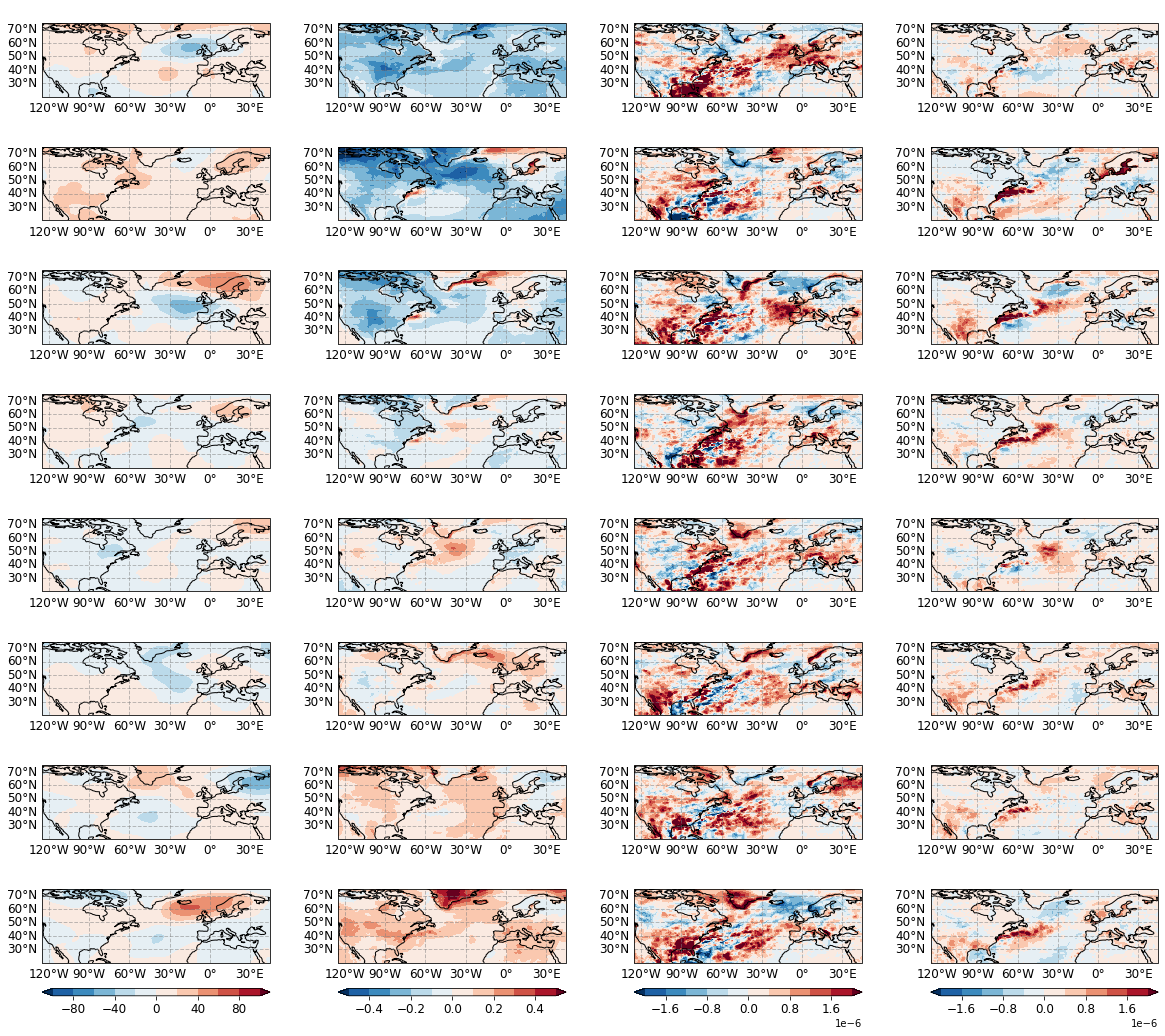

In [7]:
# Plot atmospheric var anomalies with 4-month moving average for NAO+ case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-125., 45., 20., 75.]

grid1 = plt.GridSpec(8, 4, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,18])

var_list = ['psl', 'tas', 'pr', 'evspsbl']
val = [100., 0.5, 0.2e-5, .2e-5, 0.2e-5]

tmp_ds = ds_NAOp

for j in range(0, 4): #len(var_list)):
    
    if(j==4):
        tmp1 = tmp_ds['pr'] - tmp_ds['evspsbl']
    else:
        tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,8):
        
        if (i<=8):
            tmp = (tmp1.isel(time=slice(12*i + 2 + 6, 12*i + 2 + 10)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
        else: #elif (i==3):
            tmp = (tmp1.isel(time=slice(12*i + 2 + 6, 12*(i+1) + 2 + 10)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)

        if(i==5):
            xlab = True
        else:
            xlab = False 

        if(i==0):
            titl = ' '#str(name[2])
        else: 
            titl = ' '

        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        p = plot_sec(ax, tmp, vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11,
                    lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                    orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)

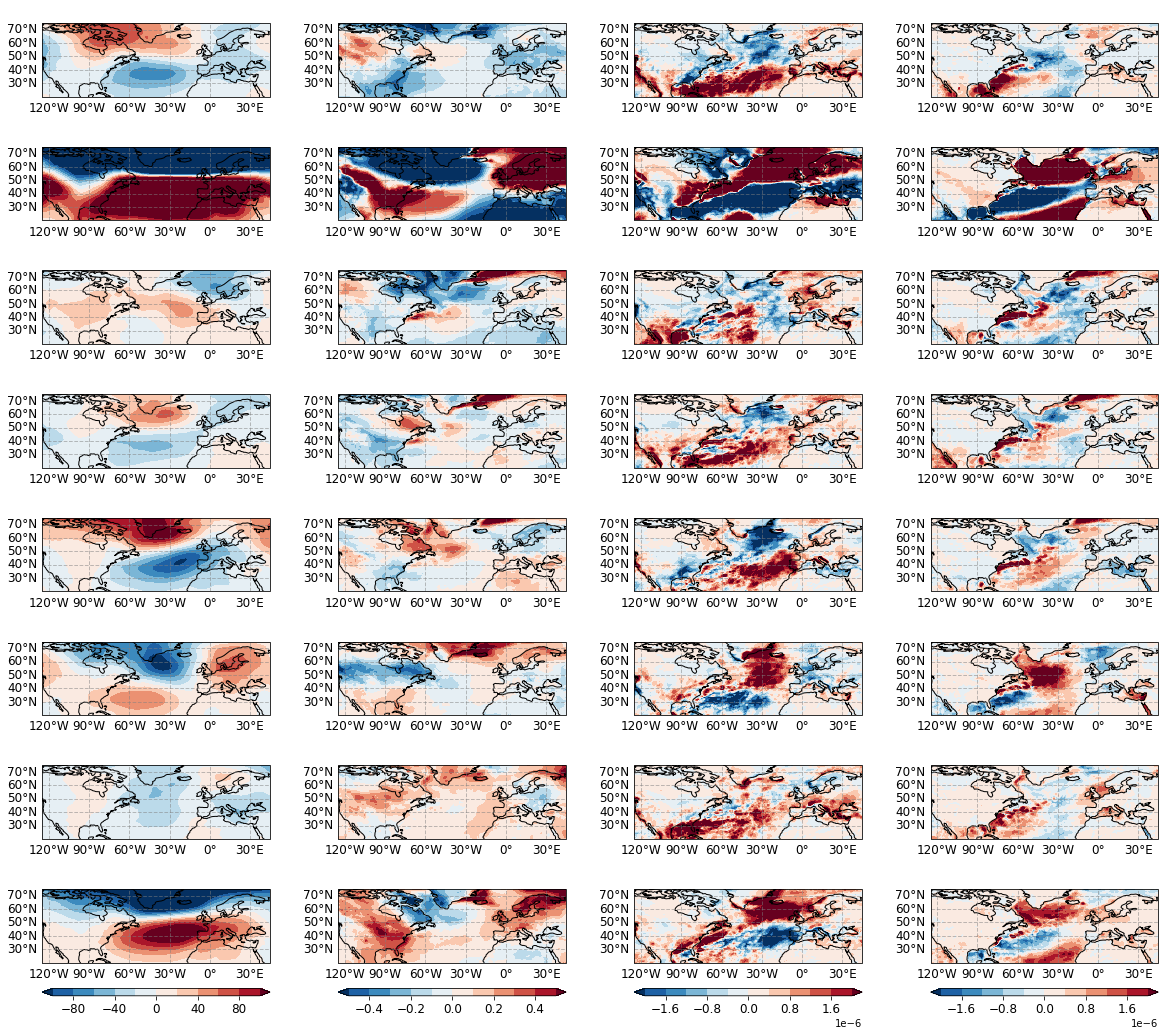

In [14]:
# Plot atmospheric var anomalies with 12-month moving average for NAO+ case

# Same as above for winter 

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-125., 45., 20., 75.]

grid1 = plt.GridSpec(8, 4, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,18])

var_list = ['psl', 'tas', 'pr', 'evspsbl']
val = [100., 0.5, 0.2e-5, .2e-5, 0.2e-5]

tmp_ds = ds_NAOp

for j in range(0, 4): #len(var_list)):
    
    if(j==4):
        tmp1 = tmp_ds['pr'] - tmp_ds['evspsbl']
    else:
        tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,8):
        
        if (i<=8):
            tmp = (tmp1.isel(time=slice(12*i + 1, 12*i + 1 + 4)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
        else: #elif (i==3):
            tmp = (tmp1.isel(time=slice(12*i + 1, 12*(i+1) + 1 + 4)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)

        if(i==5):
            xlab = True
        else:
            xlab = False 

        if(i==0):
            titl = ' '#str(name[2])
        else: 
            titl = ' '

        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        p = plot_sec(ax, tmp, vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11,
                    lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                    orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)

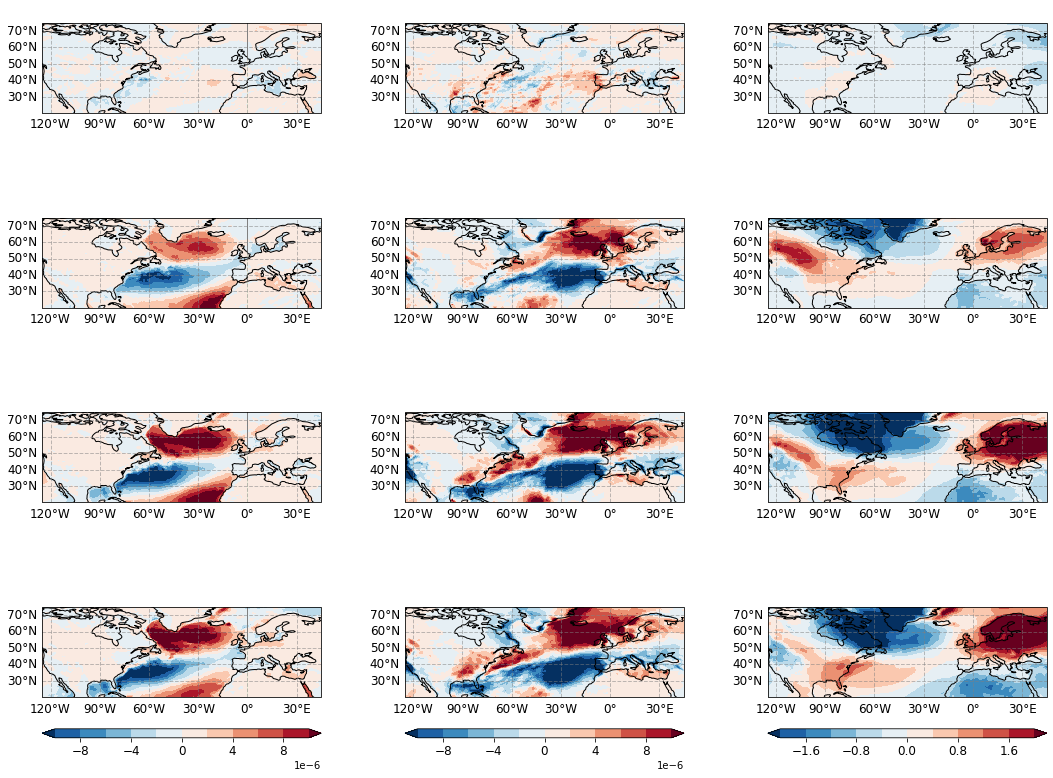

In [13]:
grid1 = plt.GridSpec(4, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,14])

for i in range(0,4):
    tmp = ds_NAOp['evspsbl'].isel(time=12 + i)
    ax = fig.add_subplot(grid1[i,0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-1e-5, vmax=1e-5,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                    loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                    bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

for i in range(0,4):
    tmp = ds_NAOp['pr'].isel(time=12 + i)
    ax = fig.add_subplot(grid1[i,1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-1e-5, vmax=1e-5,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                    loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                    bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)
    
for i in range(0,4):
    tmp = ds_NAOp['tas'].isel(time=12 + i)
    ax = fig.add_subplot(grid1[i,2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-2., vmax=2.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                    loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                    bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

### 6-month mean diagnostics

Let's look at timseries of NDJFMA and MJJASO atmospheric diagnostics to see if SST anomalies (due to delayed NAO forcing response) feedback on the atmosphere.

In [3]:
def plot_sec(ax, da, da_std = None, hatching = False, hatch_dense = 2, cfd_per = 1.96, vmin=-999, vmax=999, levels=9, 
             lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
             y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    if(hatching == True):
        #tmp_cfd = (da_std['confidence_upper'] - da_std['confidence_lower'])
        tmp_cfd = da_std['standard_error'] * cfd_per * 2.
        ax.contourf(da[lon], da[lat], np.abs(da) > np.abs(tmp_cfd), transform=ccrs.PlateCarree(), colors='none', 
                    levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'.'])
        
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return p

In [5]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/Bootstrap_Confidence/"

var_list = ['tas', 'pr', 'psl', 'clt', 'tos', 'hfds']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Bootstrap_" + case + "_" + var + "_6month.nc", chunks={'year':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

print(ds_NAOp)

<xarray.Dataset>
Dimensions:                (year: 16, lat: 99, lon: 432, j: 321, i: 361)
Coordinates:
  * lat                    (lat) float64 20.28 20.83 21.39 ... 73.61 74.17 74.72
  * lon                    (lon) float64 0.4167 1.25 2.083 ... 357.9 358.7 359.6
    height                 float64 ...
  * year                   (year) float64 -1.0 -0.5 0.0 0.5 ... 5.0 5.5 6.0 6.5
  * j                      (j) int32 780 781 782 783 784 ... 1097 1098 1099 1100
  * i                      (i) int32 810 811 812 813 814 ... 1167 1168 1169 1170
    latitude               (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude              (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Data variables: (12/24)
    tas                    (year, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>
    tas_standard_error     (year, lat, lon) float32 dask.array<chunksize=(1, 99, 432), meta=np.ndarray>
    tas_confidence_lower   (year, lat,

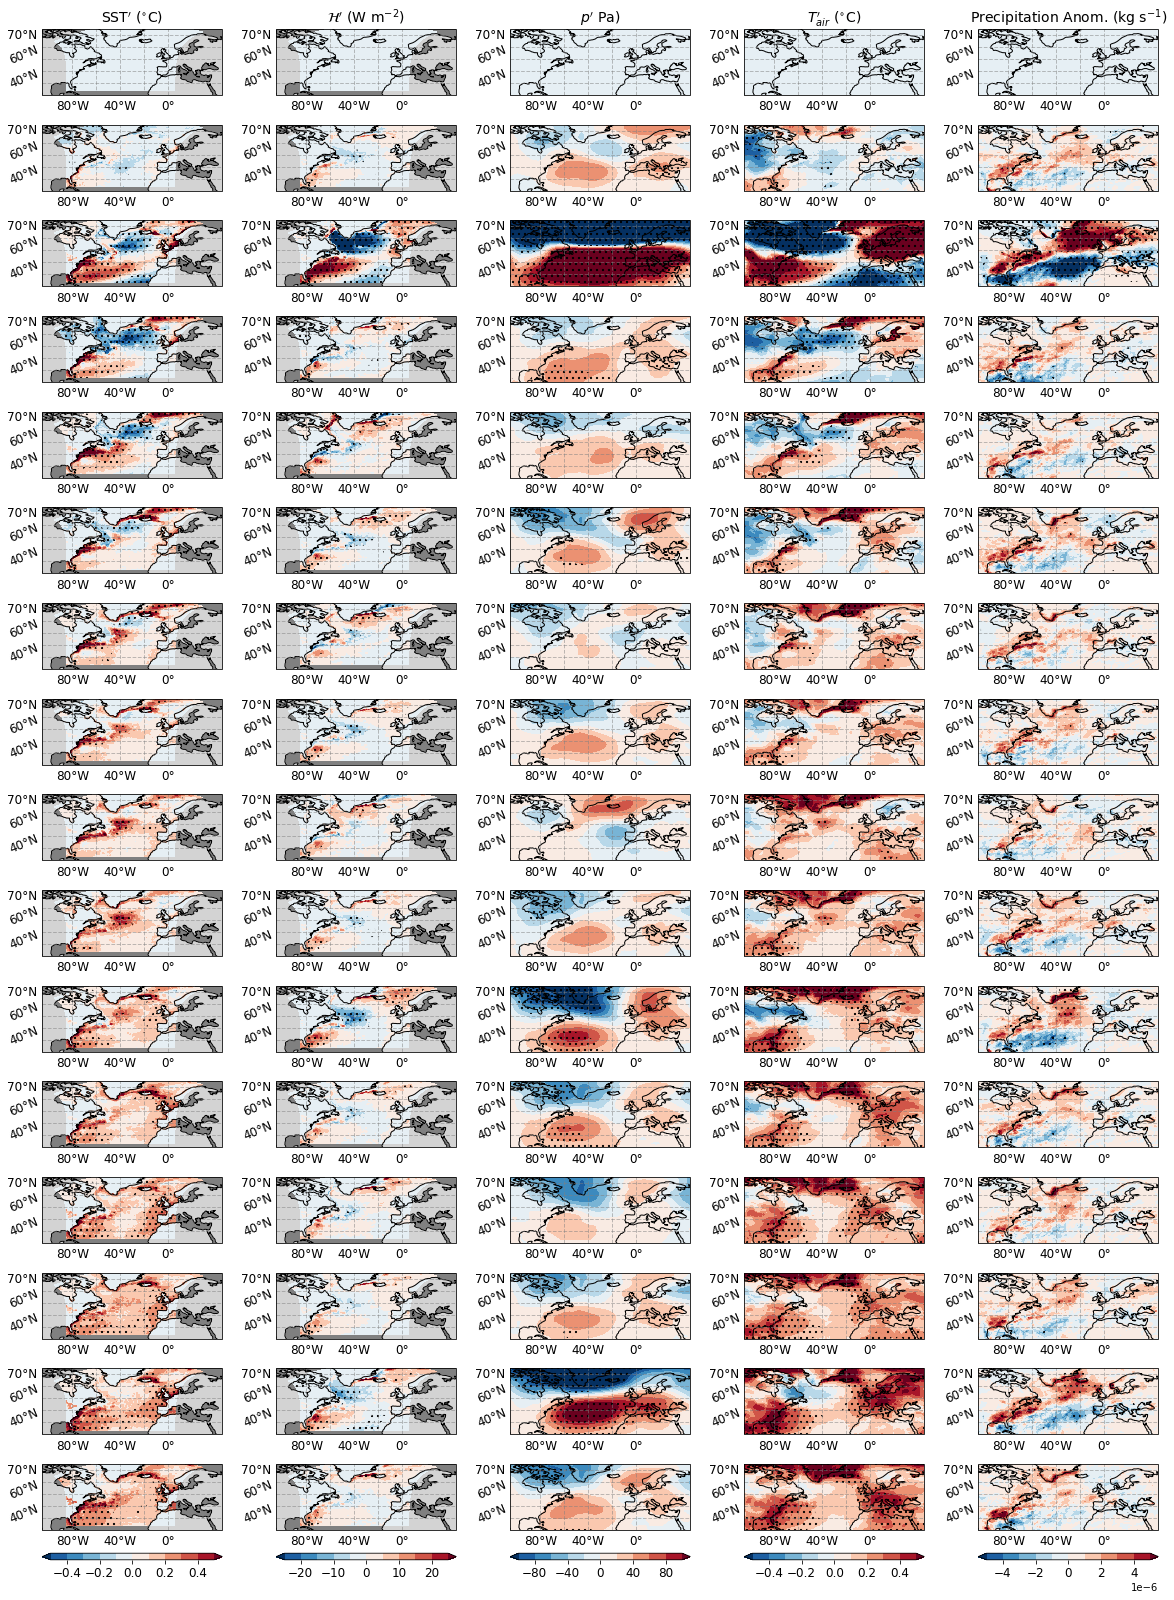

In [6]:
# NAO+ case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

lat_lon_ext = [-105., 45., 20., 75.]

grid1 = plt.GridSpec(16, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,28])

var_list = ['tos', 'hfds', 'psl', 'tas', 'pr', 'clt']
val = [0.5, 25., 100., 0.5, 0.5e-5, 1.0]

cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

name = [r'SST$^{\prime}$ ($^{\circ}$C)', r'$\mathcal{H}^{\prime}$ (W m$^{-2}$)', r'$p^{\prime}$ Pa)', r'$T^{\prime}_{air}$ ($^{\circ}$C)', 
        r'Precipitation Anom. (kg s$^{-1}$)' , 'Cloud Fraction Anom.']

tmp_ds = ds_NAOp
    
for j in range(0, 5):
    
    tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,16):
        
        tmp = tmp_ds[var_list[j]].isel(year=i) - tmp_ds[var_list[j]].isel(year=0) # 2*i for winter months and 2*i + 1 for summer months
        
        d_std = xr.Dataset()
        d_std['confidence_lower'] = tmp_ds[var_list[j] + '_confidence_lower'].isel(year=i)
        d_std['confidence_upper'] = tmp_ds[var_list[j] + '_confidence_upper'].isel(year=i)
        d_std['standard_error'] = tmp_ds[var_list[j] + '_standard_error'].isel(year=i)
        
        if(i==0):
            titl = str(name[j])
        else: 
            titl = ' '
        
        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        
        if(j<2):
            p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', 
                     cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
        else:
            p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                         vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='lon', lat='lat', 
                         cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)

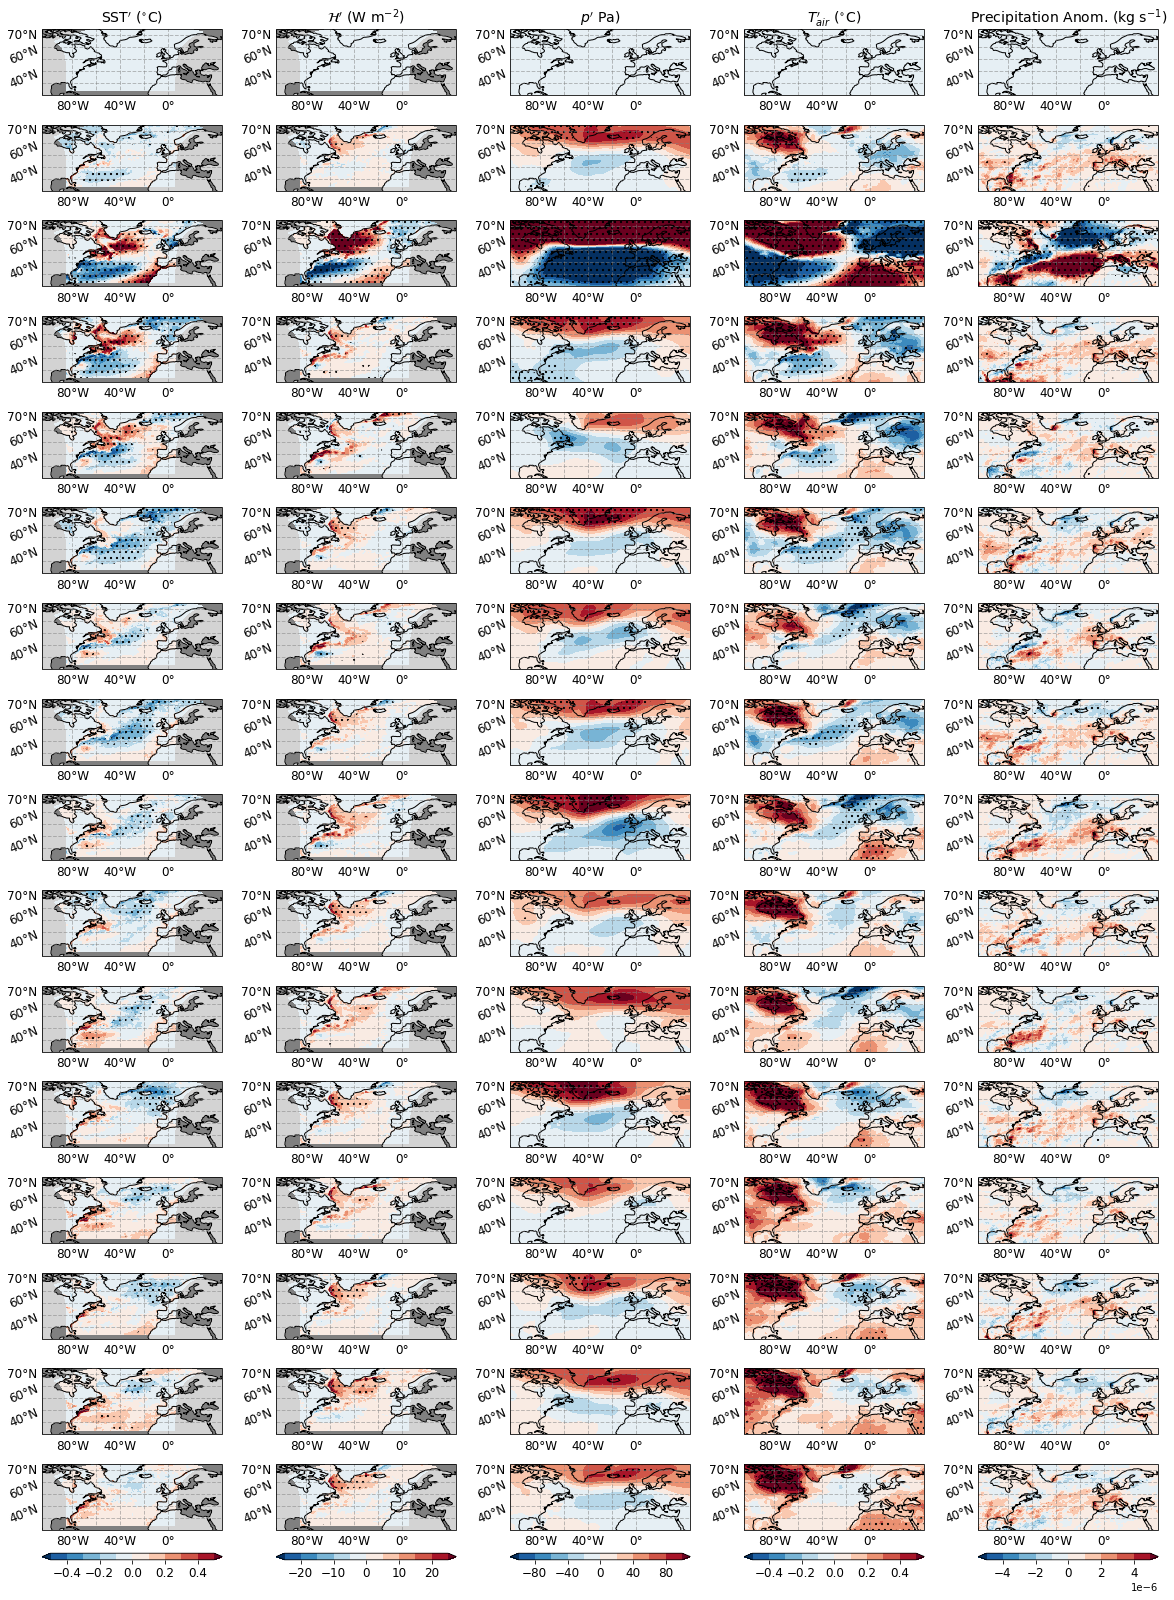

In [7]:
# NAO- case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

lat_lon_ext = [-105., 45., 20., 75.]

grid1 = plt.GridSpec(16, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,28])

var_list = ['tos', 'hfds', 'psl', 'tas', 'pr', 'clt']
val = [0.5, 25., 100., 0.5, 0.5e-5, 1.0]

cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

name = [r'SST$^{\prime}$ ($^{\circ}$C)', r'$\mathcal{H}^{\prime}$ (W m$^{-2}$)', r'$p^{\prime}$ Pa)', r'$T^{\prime}_{air}$ ($^{\circ}$C)', 
        r'Precipitation Anom. (kg s$^{-1}$)' , 'Cloud Fraction Anom.']

tmp_ds = ds_NAOn
    
for j in range(0, 5):
    
    tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,16):
        
        tmp = tmp_ds[var_list[j]].isel(year=i) - tmp_ds[var_list[j]].isel(year=0) # 2*i for winter months and 2*i + 1 for summer months
        
        d_std = xr.Dataset()
        d_std['confidence_lower'] = tmp_ds[var_list[j] + '_confidence_lower'].isel(year=i)
        d_std['confidence_upper'] = tmp_ds[var_list[j] + '_confidence_upper'].isel(year=i)
        d_std['standard_error'] = tmp_ds[var_list[j] + '_standard_error'].isel(year=i)
        
        if(i==0):
            titl = str(name[j])
        else: 
            titl = ' '
        
        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        
        if(j<2):
            p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='longitude', lat='latitude', 
                     cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
        else:
            p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                         vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='lon', lat='lat', 
                         cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)

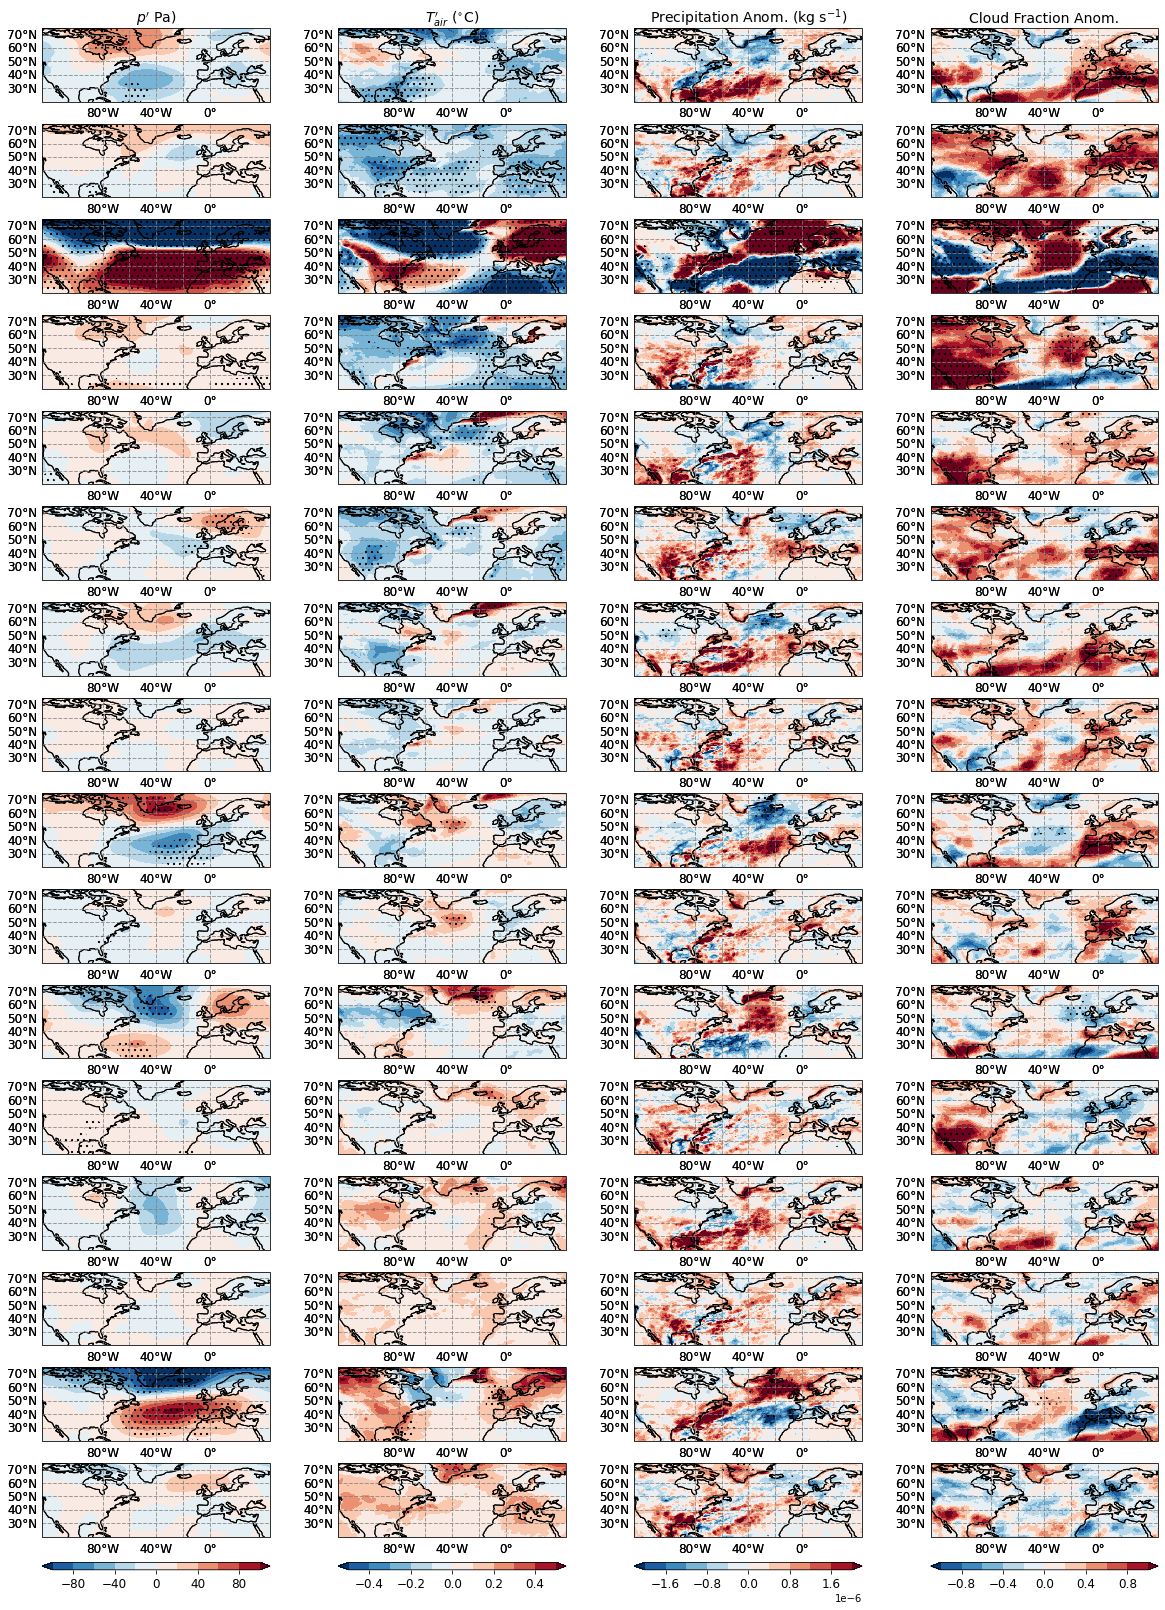

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

lat_lon_ext = [-125., 45., 20., 75.]

grid1 = plt.GridSpec(16, 4, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,28])

var_list = ['psl', 'tas', 'pr', 'clt']
val = [100., 0.5, 0.2e-5, 1.0]

cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

name = [r'$p^{\prime}$ Pa)', r'$T^{\prime}_{air}$ ($^{\circ}$C)', 
        r'Precipitation Anom. (kg s$^{-1}$)' , 'Cloud Fraction Anom.']

tmp_ds = ds_NAOp
    
for j in range(0, 4):
    
    tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,16):
        
        tmp = tmp_ds[var_list[j]].isel(year=i) # 2*i for winter months and 2*i + 1 for summer months
        
        d_std = xr.Dataset()
        d_std['confidence_lower'] = tmp_ds[var_list[j] + '_confidence_lower'].isel(year=i)
        d_std['confidence_upper'] = tmp_ds[var_list[j] + '_confidence_upper'].isel(year=i)
        d_std['standard_error'] = tmp_ds[var_list[j] + '_standard_error'].isel(year=i)
        
        if(i==0):
            titl = str(name[j])
        else: 
            titl = ' '
        
        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        p = plot_sec(ax, tmp, vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11,
                    lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                    orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
        
        p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='lon', lat='lat', 
                     cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)

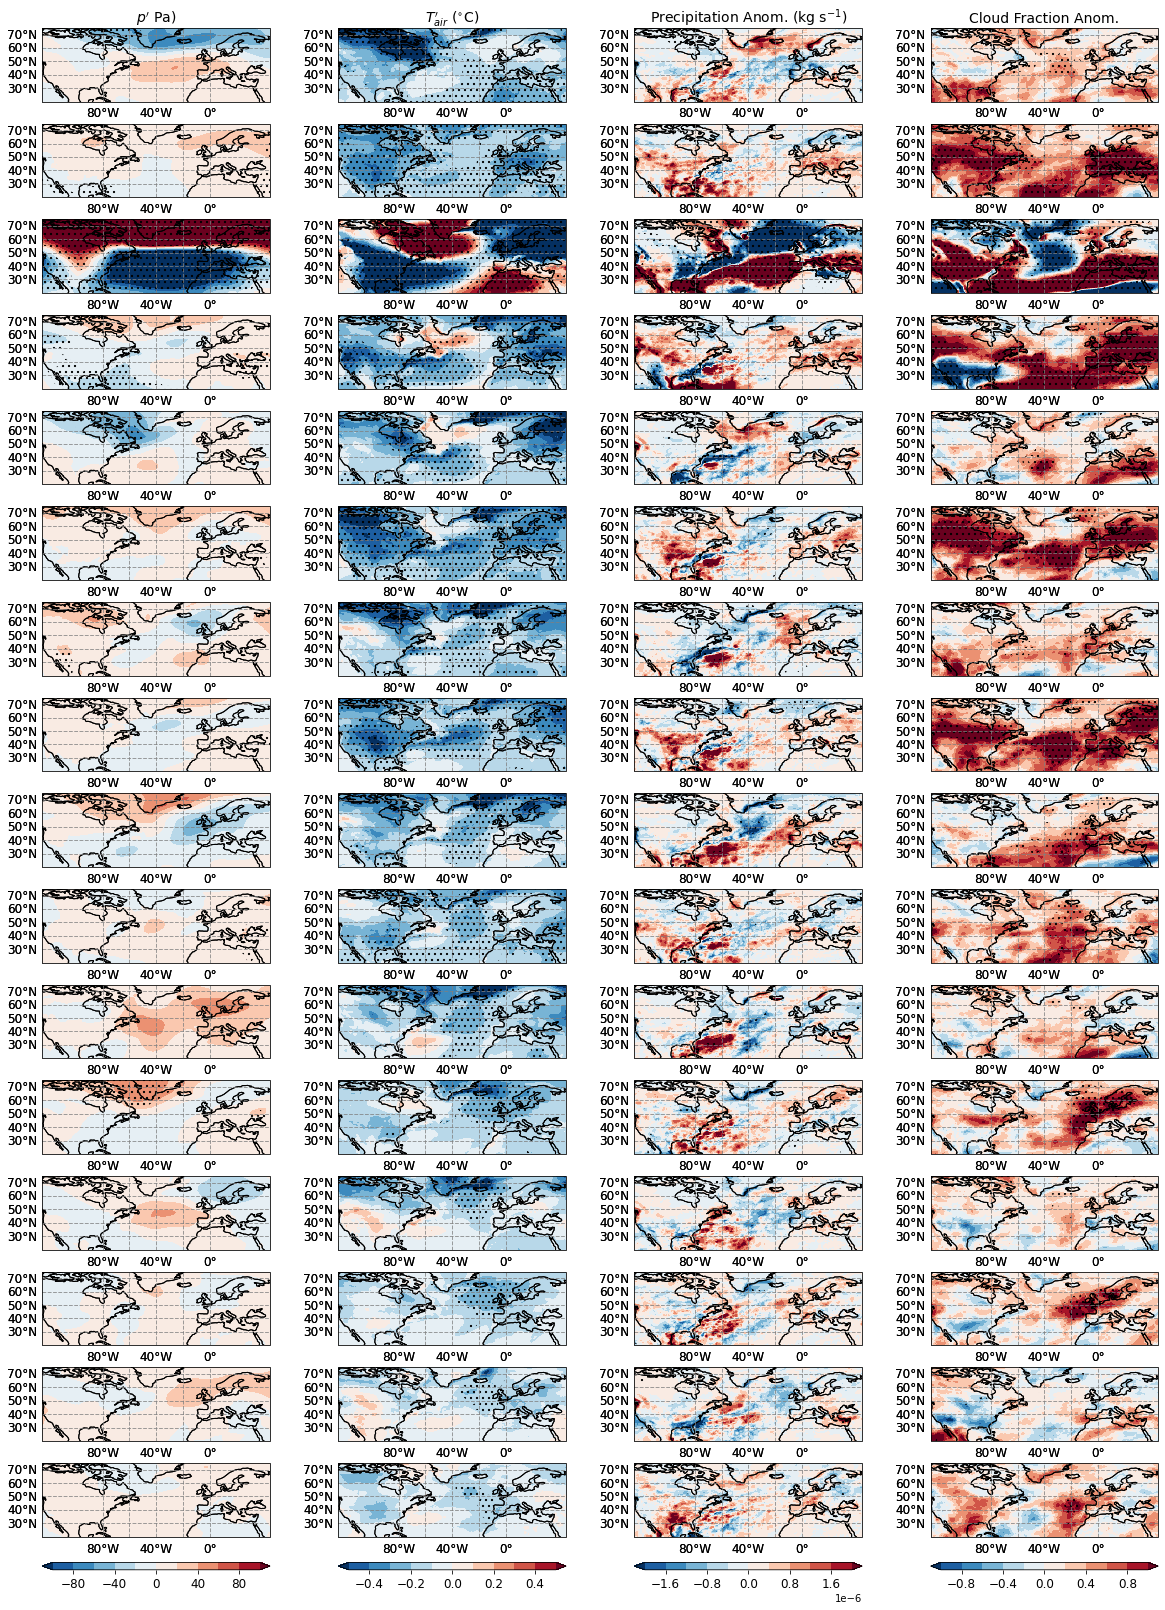

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_map = [cmaps.MPL_RdBu_r, cmaps.NEO_div_vegetation_c_r, cmaps.precip4_diff_19lev_r]

lat_lon_ext = [-125., 45., 20., 75.]

grid1 = plt.GridSpec(16, 4, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,28])

var_list = ['psl', 'tas', 'pr', 'clt']
val = [100., 0.5, 0.2e-5, 1.0]

cfd_per = 1.289 # z-val for confidence interval 
                # (1.289 for 80%, 1.658 for 90%, 1.98 for 95%, 2.617 for 99% for deg. freddom = 120)
hatch_dense = 2

name = [r'$p^{\prime}$ Pa)', r'$T^{\prime}_{air}$ ($^{\circ}$C)', 
        r'Precipitation Anom. (kg s$^{-1}$)' , 'Cloud Fraction Anom.']

tmp_ds = ds_NAOn
    
for j in range(0, 4):
    
    tmp1 = tmp_ds[var_list[j]]
    
    for i in range(0,16):
        
        tmp = tmp_ds[var_list[j]].isel(year=i) # 2*i for winter months and 2*i + 1 for summer months
        
        d_std = xr.Dataset()
        d_std['confidence_lower'] = tmp_ds[var_list[j] + '_confidence_lower'].isel(year=i)
        d_std['confidence_upper'] = tmp_ds[var_list[j] + '_confidence_upper'].isel(year=i)
        d_std['standard_error'] = tmp_ds[var_list[j] + '_standard_error'].isel(year=i)
        
        if(i==0):
            titl = str(name[j])
        else: 
            titl = ' '
        
        ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')
        p = plot_sec(ax, tmp, vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11,
                    lon='lon', lat='lat', cmap='RdBu_r', title=titl,  
                    orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
        
        p = plot_sec(ax, tmp, da_std = d_std, hatching = True, cfd_per = cfd_per, hatch_dense = hatch_dense, 
                     vmin=-val[j], vmax=val[j],  lat_lon_ext = lat_lon_ext, levels = 11, lon='lon', lat='lat', 
                     cmap=col_map[0], title=titl, orien='horizontal', colorbar=False, y_lab = True, x_lab = True)

    axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                       loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                       bbox_transform=ax.transAxes, borderpad=0,)

    cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
    cb.ax.tick_params(labelsize=12)